# Introduction to the xgbsurv package - AFT

This notebook introduces `xgbsurv` using a specific dataset. It structured by the following steps:

- Load data
- Load model
- Fit model
- Predict and evaluate model

The syntax conveniently follows that of sklearn.

In [1]:
from xgbsurv.datasets import load_metabric
from xgbsurv import XGBSurv
from xgbsurv.models.utils import sort_X_y, transform_back
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
current_path = os.getcwd() 
one_level_up = os.path.abspath(os.path.join(current_path,  ".."))

## Load Data

In [2]:
data = load_metabric(path=one_level_up+"/xgbsurv/datasets/data/", as_frame=False)
# stratify by event indicated by sign
target_sign = np.sign(data.target)
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, stratify=target_sign)
# sort data
X_train, y_train = sort_X_y(X_train, y_train)
X_test, y_test = sort_X_y(X_test, y_test)

Values are being sorted!
Values are being sorted!


## Load Model

In [3]:
model = XGBSurv(n_estimators=100, objective="aft_objective",
                                             eval_metric="aft_loss",
                                             learning_rate=0.3,
                                             random_state=42, 
                                             disable_default_eval_metric=1,
                                             )
model

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=1, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x17f724360>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=100, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x17f88f9c0>), ...)

The options of loss and objective functions can be obtained like below:

In [4]:
print(model.get_loss_functions().keys())
print(model.get_objective_functions().keys())

dict_keys(['breslow_loss', 'efron_loss', 'cind_loss', 'deephit_loss', 'aft_loss', 'ah_loss', 'eh_loss'])
dict_keys(['breslow_objective', 'efron_objective', 'cind_objective', 'deephit_objective', 'aft_objective', 'ah_objective', 'eh_objective'])


## Fit Model

In [5]:
eval_set = [(X_train, y_train)]

In [6]:
model.fit(X_train, y_train, eval_set=eval_set)

[0]	validation_0-aft_likelihood:2554.18542
[1]	validation_0-aft_likelihood:2534.26961
[2]	validation_0-aft_likelihood:2514.79900
[3]	validation_0-aft_likelihood:2495.22329
[4]	validation_0-aft_likelihood:2473.85150
[5]	validation_0-aft_likelihood:2446.74324
[6]	validation_0-aft_likelihood:2422.43445
[7]	validation_0-aft_likelihood:2404.29219
[8]	validation_0-aft_likelihood:2389.26978
[9]	validation_0-aft_likelihood:2373.48454
[10]	validation_0-aft_likelihood:2350.77725
[11]	validation_0-aft_likelihood:2326.95093
[12]	validation_0-aft_likelihood:2321.53376
[13]	validation_0-aft_likelihood:2312.04458
[14]	validation_0-aft_likelihood:2299.01395
[15]	validation_0-aft_likelihood:2282.00081
[16]	validation_0-aft_likelihood:2254.40943
[17]	validation_0-aft_likelihood:2238.13440
[18]	validation_0-aft_likelihood:2227.57456
[19]	validation_0-aft_likelihood:2215.30066
[20]	validation_0-aft_likelihood:2206.27383
[21]	validation_0-aft_likelihood:2198.70920
[22]	validation_0-aft_likelihood:2186.9108

XGBSurv(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
        colsample_bynode=None, colsample_bytree=None,
        disable_default_eval_metric=1, early_stopping_rounds=None,
        enable_categorical=False,
        eval_metric=CPUDispatcher(<function aft_likelihood at 0x17f724360>),
        feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
        importance_type=None, interaction_constraints=None, learning_rate=0.3,
        max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
        max_delta_step=None, max_depth=None, max_leaves=None,
        min_child_weight=None, missing=nan, monotone_constraints=None,
        n_estimators=100, n_jobs=None, num_parallel_tree=None,
        objective=CPUDispatcher(<function aft_objective at 0x17f88f9c0>), ...)

The model can be saved like below. Note that objective and eval_metric are not saved.

In [7]:
#model.save_model("introduction_model_breslow.json")

## Predict

In [8]:
preds_train = model.predict(X_train, output_margin=True)
preds_test = model.predict(X_test, output_margin=True)

### Predict Cumulative Hazard

In [9]:
df_cum_hazards = model.predict_cumulative_hazard_function(X_train, X_test, y_train, y_test)
df_cum_hazards.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
298.033325,4.934182,3.294833,0.470793,1.543050,5.024541,0.661493,1.319198,0.123189,1.154556,1.012374,...,2.460112,3.176105,0.485375,6.318718,2.249832,0.600944,1.185147,1.761367,1.716226,1.838036
307.633331,5.119298,3.467880,0.485102,1.647663,5.209711,0.694434,1.409802,0.137489,1.233216,1.079563,...,2.608584,3.345973,0.500351,6.486617,2.389834,0.627012,1.266258,1.878496,1.830940,1.959081
335.600006,5.625728,3.959672,0.528509,1.966391,5.711171,0.804628,1.689048,0.180789,1.479232,1.292472,...,3.042008,3.832781,0.547077,6.919723,2.801914,0.714656,1.518857,2.230132,2.175723,2.322145


## Predict Survival Function

In [10]:
df_survival_function = model.predict_survival_function(X_train, X_test, y_train, y_test)
df_survival_function.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,466,467,468,469,470,471,472,473,474,475
298.033325,0.007196,0.037074,0.624507,0.213728,0.006575,0.516080,0.267350,0.884096,0.315198,0.363355,...,0.085425,0.041748,0.615466,0.001802,0.105417,0.548294,0.305701,0.171810,0.179743,0.159130
307.633331,0.005980,0.031183,0.615634,0.192499,0.005463,0.499357,0.244192,0.871544,0.291354,0.339744,...,0.073639,0.035226,0.606318,0.001524,0.091645,0.534186,0.281884,0.152820,0.160263,0.140988
335.600006,0.003604,0.019069,0.589483,0.139961,0.003309,0.447254,0.184695,0.834612,0.227813,0.274591,...,0.047739,0.021649,0.578639,0.000988,0.060694,0.489360,0.218962,0.107514,0.113526,0.098063


### Visualize Predictions

Text(0.5, 1.0, 'Cumulative Hazard AFT')

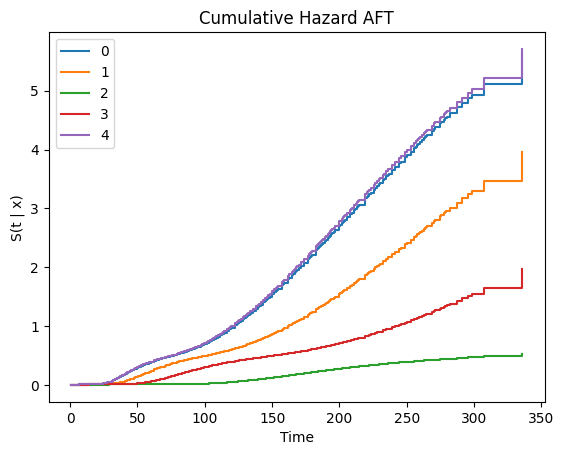

In [11]:
df_cum_hazards.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Cumulative Hazard AFT")

Text(0.5, 1.0, 'Survival Curve AFT')

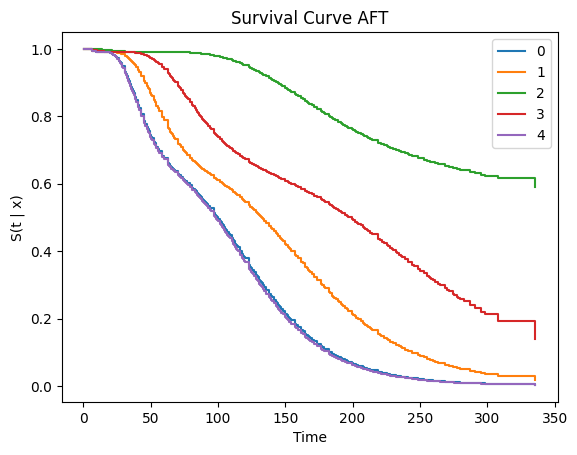

In [12]:
df_survival_function.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
plt.title("Survival Curve AFT")

## Evaluate

### Test

In [13]:
durations_test, events_test = transform_back(y_test)
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(df_survival_function, durations_test, events_test, censor_surv='km')
print('Concordance Index',ev.concordance_td('antolini'))

Concordance Index 0.5906403174356182


In [14]:
print('Integrated Brier Score:',ev.integrated_brier_score(time_grid))

Integrated Brier Score: 0.18750317575577505
